In [8]:
import os
import time
import json
import numpy as np
import torch
import joblib
from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data.trajectory_loader import load_dataset
from models.attention_bi_gru_predictor import TrajPredictor
from utils.logger import get_logger
from utils.model_evaluator import evaluate_metrics_multi_agent_per_timestep as evaluate
from utils.plot_generator import plot_trajectories, plot_3d_trajectories_subplots
from utils.scaler import scale_per_agent

In [9]:
# pylint: disable=all
# Data settings and parameters
DATA_TYPE = "zurich"  # Options: "zurich", "quadcopter", "mixed"
SEQUENTIAL_PREDICTION = (
    True  # If False, model predicts only the last point for FORWARD_LEN steps
)
AGENTS = 3  # Number of agents or drones
LOOK_BACK = 50  # Number of past time steps to use as input
FORWARD_LEN = 5  # Number of future time steps to predict
FEATURES_PER_AGENT = 3  # x, y, z

# Training parameters
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3

# Plotting parameters
NUM_PLOTS = 2  # number of plots to generate
NUM_SUBPLOTS = 2  # number of subplots to generate

In [10]:
# Setup logger and experiment folder
logger, exp_dir = get_logger()
os.makedirs(exp_dir, exist_ok=True)

logger.info("Experiment started")
logger.info("Experiment folder: %s", exp_dir)
logger.info("Dataset: %s", DATA_TYPE)
logger.info("Number of drones (agents): %d", AGENTS)
logger.info("LOOK_BACK (past steps): %d", LOOK_BACK)
logger.info("FORWARD_LEN (future steps): %d", FORWARD_LEN)
logger.info("SEQUENTIAL_PREDICTION: %s", "True" if SEQUENTIAL_PREDICTION else "False")

2025-10-01 09:49:16,287 - INFO - Experiment started
2025-10-01 09:49:16,288 - INFO - Experiment folder: experiments/20251001_094916
2025-10-01 09:49:16,289 - INFO - Dataset: zurich
2025-10-01 09:49:16,290 - INFO - Number of drones (agents): 3
2025-10-01 09:49:16,291 - INFO - LOOK_BACK (past steps): 50
2025-10-01 09:49:16,292 - INFO - FORWARD_LEN (future steps): 5
2025-10-01 09:49:16,293 - INFO - SEQUENTIAL_PREDICTION: True


In [11]:
# Load DataFrame
df = load_dataset(
    DATA_TYPE,
    min_rows=800,
    num_flights=AGENTS,
)

# Prepare sequences
# Track trajectory indices to be used in plotting later
X, y, trajectory_ids = [], [], []

for traj_idx in df["trajectory_index"].unique():
    traj_df = df[df["trajectory_index"] == traj_idx].reset_index(drop=True)

    # Drop trajectory_index for features
    traj_data = traj_df.drop(columns=["trajectory_index"]).values.astype(np.float32)
    n_rows = traj_data.shape[0]

    seq_count = n_rows - LOOK_BACK - FORWARD_LEN + 1
    for i in range(seq_count):
        seq_X = traj_data[i : i + LOOK_BACK]  # shape (LOOK_BACK, features)

        # For sequential prediction, predict FORWARD_LEN steps; else just the last step
        if SEQUENTIAL_PREDICTION:
            seq_y = traj_data[
                i + LOOK_BACK : i + LOOK_BACK + FORWARD_LEN
            ]  # shape (FORWARD_LEN, features)
        else:
            seq_y = traj_data[
                i + LOOK_BACK + FORWARD_LEN - 1 : i + LOOK_BACK + FORWARD_LEN
            ]  # (1, features)

        X.append(seq_X)
        y.append(seq_y)
        trajectory_ids.append(traj_idx)


In [12]:
# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # (num_sequences, LOOK_BACK, features)
y = np.array(
    y, dtype=np.float32
)  # (num_sequences, 1, features) or (num_sequences, FORWARD_LEN, features)
trajectory_ids = np.array(trajectory_ids)

# Split train/test
X_train, X_test, y_train, y_test, traj_train, traj_test = train_test_split(
    X, y, trajectory_ids, test_size=0.2, shuffle=False
)

# Get feature dimension dynamically
num_features_X = X_train.shape[-1]

# Scale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scale_per_agent(X_train, scaler_X, FEATURES_PER_AGENT, fit=True)
X_test_scaled = scale_per_agent(X_test, scaler_X, FEATURES_PER_AGENT, fit=False)

y_train_scaled = scale_per_agent(y_train, scaler_y, FEATURES_PER_AGENT, fit=True)
y_test_scaled = scale_per_agent(y_test, scaler_y, FEATURES_PER_AGENT, fit=False)

# Save scalers
joblib.dump(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

# Convert to tensors
X_train_tensor = torch.tensor(
    X_train_scaled, dtype=torch.float32
)  # (num_sequences, LOOK_BACK, features)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False
)

In [13]:
# Log dataset sizes
total_sequences = X_train_tensor.shape[0] + X_test_tensor.shape[0]
logger.info("Total sequences: %d", total_sequences)
logger.info("Train sequences: %s", X_train_tensor.shape)
logger.info("Test sequences: %s", X_test_tensor.shape)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

2025-10-01 09:49:16,686 - INFO - Total sequences: 23126
2025-10-01 09:49:16,687 - INFO - Train sequences: torch.Size([18500, 50, 9])
2025-10-01 09:49:16,688 - INFO - Test sequences: torch.Size([4626, 50, 9])
2025-10-01 09:49:16,688 - INFO - Using device: cpu


In [ ]:
# Model, criterion, optimizer
model_params = {
    "enc_hidden_size": 64,
    "dec_hidden_size": 64,
    "num_layers": 1,
}
model = TrajPredictor(**model_params).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Log model info
logger.info("Model module: %s", model.__class__.__module__)
logger.info("Model architecture:\n%s", model)

2025-10-01 09:49:17,540 - INFO - Model module: models.attention_bi_gru_predictor
2025-10-01 09:49:17,541 - INFO - Model architecture:
TrajPredictor(
  (encoder): GRU(3, 128, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=320, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (enc_to_dec): Linear(in_features=256, out_features=64, bias=True)
  (decoder): GRU(259, 64, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)


In [15]:
# Log training time
training_start = time.time()

# Early stopping parameters
patience = 10
best_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Training Loop
model.train()
try:
    for epoch in range(EPOCHS):
        total_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()

            # Add prediction_len argument if sequential prediction
            if SEQUENTIAL_PREDICTION:
                pred = model(batch_x, pred_len=FORWARD_LEN)
            else:
                pred = model(batch_x, pred_len=1)

            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logger.info("Epoch %d/%d - Train Loss: %.7f", epoch + 1, EPOCHS, avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(exp_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        # If no improvement for 'patience' epochs, stop training
        if epochs_no_improve >= patience:
            logger.info("Early stopping triggered after %d epochs", epoch + 1)
            early_stop = True
            break

except KeyboardInterrupt:
    logger.warning("Training interrupted by user! Running evaluation...")

# Save last-epoch model
finally:
    torch.save(model.state_dict(), os.path.join(exp_dir, "last_model.pt"))

# If training completed without early stopping
if not early_stop:
    logger.info("Training finished without early stopping.")

# Log total training time
training_end_time = time.time()
elapsed_time = training_end_time - training_start
logger.info("Total training time: %.2f seconds", elapsed_time)

2025-10-01 09:51:22,923 - INFO - Epoch 1/500 - Train Loss: 0.0041951
2025-10-01 09:55:04,212 - INFO - Epoch 2/500 - Train Loss: 0.0000429
2025-10-01 09:57:08,820 - INFO - Epoch 3/500 - Train Loss: 0.0000287
2025-10-01 09:59:13,035 - INFO - Epoch 4/500 - Train Loss: 0.0000358
2025-10-01 10:01:20,733 - INFO - Epoch 5/500 - Train Loss: 0.0000359
2025-10-01 10:03:48,483 - INFO - Epoch 6/500 - Train Loss: 0.0000473
2025-10-01 10:06:00,439 - INFO - Epoch 7/500 - Train Loss: 0.0000312
2025-10-01 10:12:09,778 - INFO - Epoch 8/500 - Train Loss: 0.0000304
2025-10-01 10:14:14,543 - INFO - Epoch 9/500 - Train Loss: 0.0000298
2025-10-01 10:16:20,271 - INFO - Epoch 10/500 - Train Loss: 0.0000229
2025-10-01 10:19:39,870 - INFO - Epoch 11/500 - Train Loss: 0.0000343
2025-10-01 10:23:30,146 - INFO - Epoch 12/500 - Train Loss: 0.0000550
2025-10-01 10:25:35,687 - INFO - Epoch 13/500 - Train Loss: 0.0000147
2025-10-01 10:28:13,466 - INFO - Epoch 14/500 - Train Loss: 0.0000155
2025-10-01 10:30:18,085 - INF

In [16]:
# Evaluation parameters
all_preds, all_trues = [], []
inference_times = []
test_loss = 0.0
total_sequences = 0

model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        total_sequences += batch_x.size(0)

        # Measure inference time
        start_time = time.time()

        # Add prediction_len argument if sequential prediction
        if SEQUENTIAL_PREDICTION:
            outputs = model(batch_x, pred_len=FORWARD_LEN)
        else:
            outputs = model(batch_x, pred_len=1)

        end_time = time.time()

        # Record inference time per batch
        inference_times.append(end_time - start_time)

        # Compute test loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions and true values
        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Compute total inference time, average inference time per batch and per sequence
total_inf_time = sum(inference_times)
avg_inf_time_per_seq = total_inf_time / total_sequences
avg_inf_time_per_batch = total_inf_time / len(test_loader)

# Log final test metrics
logger.info("Test Loss (scaled): %.7f", avg_test_loss)
logger.info("Average inference time per sequence: %.6f seconds", avg_inf_time_per_seq)
logger.info("Average inference time per batch: %.6f seconds", avg_inf_time_per_batch)

2025-10-01 10:47:05,586 - INFO - Test Loss (scaled): 0.0000291
2025-10-01 10:47:05,586 - INFO - Average inference time per sequence: 0.002310 seconds
2025-10-01 10:47:05,587 - INFO - Average inference time per batch: 0.073706 seconds


In [17]:
# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_trues, dim=0)

# Compute evaluation metrics (inverse scaling applied)
mse_t, rmse_t, mae_t, ede_t, axis_mse_t, axis_rmse_t, axis_mae_t = evaluate(
    y_true, y_pred, scaler_y, num_agents=AGENTS
)

# Table header
header = (
    f"{'Timestep':>8} | {'EDE':>10} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | "
    f"{'MSE_x':>10} {'MSE_y':>10} {'MSE_z':>10} | "
    f"{'RMSE_x':>10} {'RMSE_y':>10} {'RMSE_z':>10} | "
    f"{'MAE_x':>10} {'MAE_y':>10} {'MAE_z':>10}"
)
logger.info("-" * len(header))
logger.info(header)
logger.info("-" * len(header))

# Table rows
for t, (ede, mse, rmse, mae, axis_mse, axis_rmse, axis_mae) in enumerate(
    zip(ede_t, mse_t, rmse_t, mae_t, axis_mse_t, axis_rmse_t, axis_mae_t)
):
    logger.info(
        "%8d | %10.6f | %10.6f | %10.6f | %10.6f | "
        "%10.6f %10.6f %10.6f | "
        "%10.6f %10.6f %10.6f | "
        "%10.6f %10.6f %10.6f",
        t,
        ede,
        mse,
        rmse,
        mae,
        axis_mse[0],
        axis_mse[1],
        axis_mse[2],
        axis_rmse[0],
        axis_rmse[1],
        axis_rmse[2],
        axis_mae[0],
        axis_mae[1],
        axis_mae[2],
    )

# Summary averages
logger.info("-" * len(header))
logger.info(
    "%8s | %10.6f | %10.6f | %10.6f | %10.6f | "
    "%10.6f %10.6f %10.6f | "
    "%10.6f %10.6f %10.6f | "
    "%10.6f %10.6f %10.6f",
    "Average",
    ede_t.mean(),
    mse_t.mean(),
    rmse_t.mean(),
    mae_t.mean(),
    axis_mse_t.mean(axis=0)[0],
    axis_mse_t.mean(axis=0)[1],
    axis_mse_t.mean(axis=0)[2],
    axis_rmse_t.mean(axis=0)[0],
    axis_rmse_t.mean(axis=0)[1],
    axis_rmse_t.mean(axis=0)[2],
    axis_mae_t.mean(axis=0)[0],
    axis_mae_t.mean(axis=0)[1],
    axis_mae_t.mean(axis=0)[2],
)
logger.info("-" * len(header))

2025-10-01 10:47:05,600 - INFO - ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
2025-10-01 10:47:05,601 - INFO - Timestep |        EDE |        MSE |       RMSE |        MAE |      MSE_x      MSE_y      MSE_z |     RMSE_x     RMSE_y     RMSE_z |      MAE_x      MAE_y      MAE_z
2025-10-01 10:47:05,601 - INFO - ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
2025-10-01 10:47:05,602 - INFO -        0 |   2.465270 |   2.867514 |   1.693374 |   0.987304 |   0.465458   8.101718   0.035360 |   0.682245   2.846352   0.188042 |   0.568770   2.268842   0.124306
2025-10-01 10:47:05,602 - INFO -        1 |   2.587860 |   3.066472 |   1.751135 |   1.127346 |   1.351786   7.789725   0.057905 |   1.162664   2.791008   0.240635 |   1.059878   2.164929   0.157222
2025-

In [18]:
# Save config / hyperparameters
config = {
    "device": str(device),
    "model_module": model.__class__.__module__,
    "model_class": model.__class__.__name__,
    "model_params": model_params,
    "DATA_TYPE": DATA_TYPE,
    "AGENTS": AGENTS,
    "FEATURES_PER_AGENT": FEATURES_PER_AGENT,
    "LOOK_BACK": LOOK_BACK,
    "FORWARD_LEN": FORWARD_LEN,
    "SEQUENTIAL_PREDICTION": SEQUENTIAL_PREDICTION,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
}

config_path = os.path.join(exp_dir, "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

logger.info("Config saved to %s", config_path)

2025-10-01 10:47:05,611 - INFO - Config saved to experiments/20251001_094916/config.json


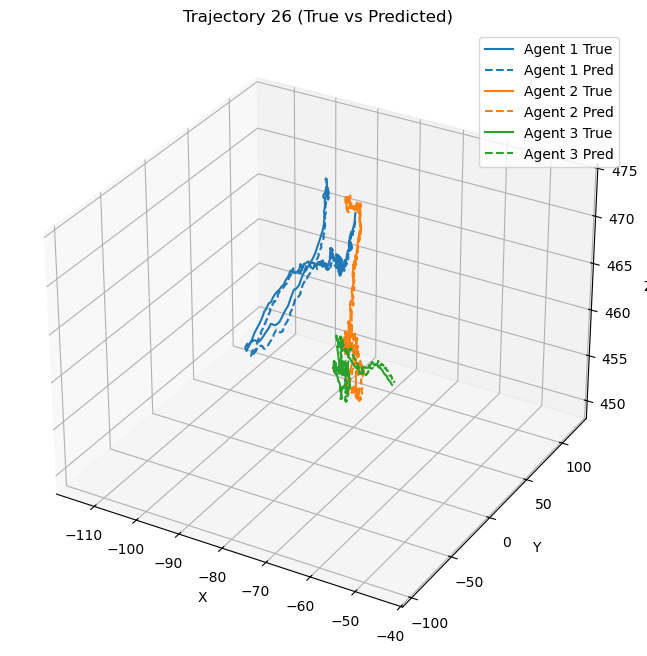

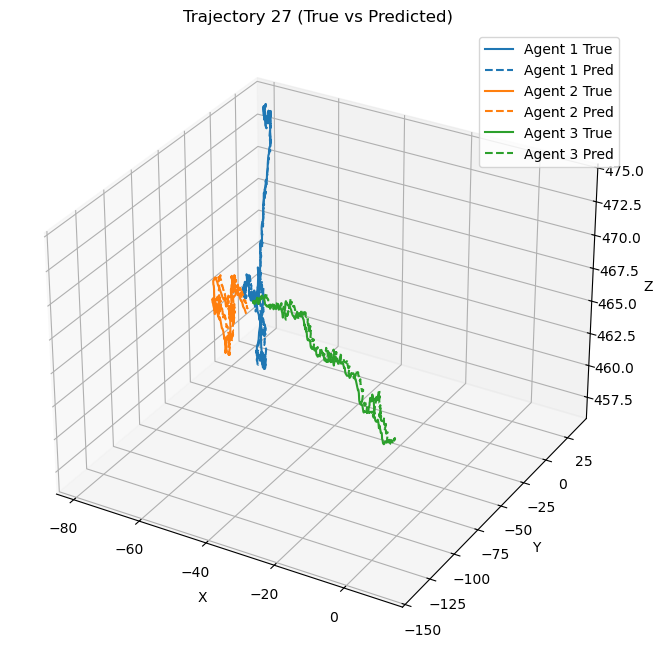

In [19]:
# Group results back by trajectory_index
traj_test = traj_test[: len(y_true)]  # align just in case
unique_trajs = np.unique(traj_test)

# Randomly select trajectories to plot
plot_trajs = np.random.choice(
    unique_trajs, size=min(NUM_PLOTS, len(unique_trajs)), replace=False
).tolist()

# Plot trajectories using the helper function
plot_trajectories(
    y_true=y_true.numpy(),
    y_pred=y_pred.numpy(),
    traj_ids=traj_test,
    plot_trajs=plot_trajs,
    scaler=scaler_y,
    agents=AGENTS,
    save_dir=exp_dir,
)

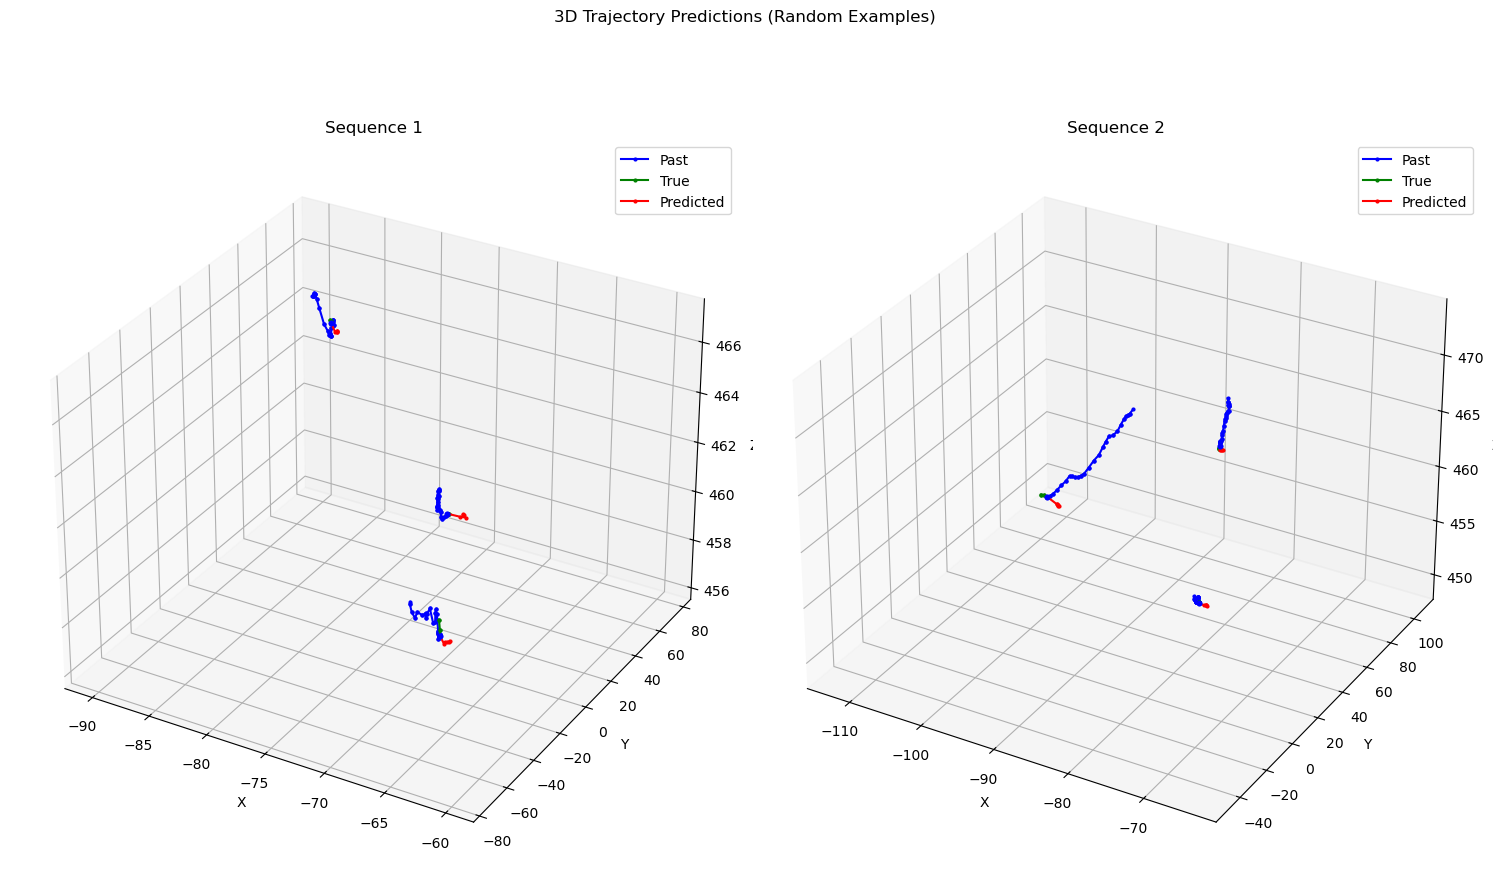

In [20]:
# Stack all past inputs (for context)
past_inputs = torch.cat(
    [b for b, _ in test_loader], dim=0
).numpy()  # (num_sequences, LOOK_BACK, num_features)

# Ensure NUM_PLOTS does not exceed number of sequences
num_sequences = y_true.shape[0]
NUM_SUBPLOTS = min(NUM_SUBPLOTS, num_sequences)

# Randomly select sequence indices for plotting
plot_indices = np.random.choice(num_sequences, size=NUM_SUBPLOTS, replace=False)

trajectory_sets = []

for seq_idx in plot_indices:
    past = past_inputs[seq_idx]  # shape: (LOOK_BACK, features)
    true_future = y_true[seq_idx]  # shape: (seq_len, features)
    pred_future = y_pred[seq_idx]  # shape: (seq_len, features)

    # Inverse scale past and future
    past_orig = scale_per_agent(past, scaler_X, FEATURES_PER_AGENT, inverse=True)
    true_future_orig = scale_per_agent(
        true_future, scaler_y, FEATURES_PER_AGENT, inverse=True
    )
    pred_future_orig = scale_per_agent(
        pred_future, scaler_y, FEATURES_PER_AGENT, inverse=True
    )

    # Concatenate last past point with future to make continuous lines
    true_line = np.vstack([past_orig[-1:], true_future_orig])
    pred_line = np.vstack([past_orig[-1:], pred_future_orig])

    trajectory_sets.append((past_orig, true_line, pred_line))

# Create subplots for selected sequences
plot_path = Path(exp_dir) / "training_subplots.png"
plot_3d_trajectories_subplots(trajectory_sets, per_agent=True, save_path=str(plot_path))